In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from pandas.plotting import table

# Load sentiment data
sentiment_data = pd.read_csv("predictions2.csv")
unique_stocks = sentiment_data["stock"].unique()

# Initialize LabelEncoder
encoder = LabelEncoder()
encoder.fit(unique_stocks)

# Function to fetch stock data and compute technical indicators
def get_stock_data(ticker):
    stock = yf.download(ticker, start="2024-01-01", end="2025-02-26", interval="1d")
    stock.columns = stock.columns.droplevel(1) if isinstance(stock.columns, pd.MultiIndex) else stock.columns
    stock["Stock"] = ticker  # Add stock identifier
    
    # Calculate EMA
    stock["EMA_10"] = stock["Close"].ewm(span=10, adjust=False).mean()
    stock["EMA_25"] = stock["Close"].ewm(span=25, adjust=False).mean()

    # MACD Calculation
    short_ema = stock["Close"].ewm(span=12, adjust=False).mean()
    long_ema = stock["Close"].ewm(span=26, adjust=False).mean()
    stock["MACD_12_26_9"] = short_ema - long_ema
    stock["MACDs_12_26_9"] = stock["MACD_12_26_9"].ewm(span=9, adjust=False).mean()
    stock["MACDh_12_26_9"] = stock["MACD_12_26_9"] - stock["MACDs_12_26_9"]

    # Bollinger Bands
    stock["BBM_5"] = stock["Close"].rolling(window=5).mean()
    stock["BBU_5"] = stock["BBM_5"] + (stock["Close"].rolling(window=5).std() * 1)
    stock["BBL_5"] = stock["BBM_5"] - (stock["Close"].rolling(window=5).std() * 1)
    stock["BBB_5"] = (stock["BBU_5"] - stock["BBL_5"]) / stock["BBM_5"]
    stock["BBP_5"] = (stock["Close"] - stock["BBL_5"]) / (stock["BBU_5"] - stock["BBL_5"])
    stock["target_1"] = stock["Close"].shift(-1)
    
    # Encode stock name
    stock["Stock"] = encoder.transform([ticker])[0]
    
    return stock.iloc[:-1]  # Remove last row

# Fetch and combine data for all stocks
all_data = pd.concat([get_stock_data(stock) for stock in unique_stocks])
all_data = all_data.reset_index()
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data = all_data[all_data['Date'] >= '2025-01-22']
sen_data = all_data.copy()
all_data = all_data.drop(columns=["Date"])
all_data = all_data.dropna()
sentiment_data = sentiment_data.rename(columns={'stock': 'Stock', 'date': 'Date'})
sentiment_data["Stock"] = encoder.transform(sentiment_data["Stock"])
sen_data['Date'] = pd.to_datetime(sen_data['Date'])
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])
merged_data = sen_data.merge(sentiment_data, on=['Date', 'Stock'], how='left')
merged_data = merged_data.drop(columns=["Date"])
merged_data = merged_data.dropna()

# Split features and target
features = all_data.drop(columns=["target_1","Open"])
target = all_data["target_1"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=1)

# Train the model
model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate MSE, MAPE, and R² for test set
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"\nModel Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"R-squared (R²): {r2:.4f}")
def predict_next_days(model, last_row, feature_columns, days=5):
    predictions = []
    last_row = last_row.copy()
    
    for _ in range(days):
        feature_data = pd.DataFrame([last_row[feature_columns]])

        # Predict the next price
        predicted_price = model.predict(feature_data)[0]
        predictions.append(predicted_price)

        # Update the last row with new predicted price
        last_row["Close"] = predicted_price

        # Recalculate EMA
        last_row["EMA_10"] = (last_row["EMA_10"] * 9 + predicted_price) / 10
        last_row["EMA_25"] = (last_row["EMA_25"] * 24 + predicted_price) / 25

        # Recalculate MACD components
        short_ema = (last_row["MACD_12_26_9"] * 11 + predicted_price) / 12
        long_ema = (last_row["MACD_12_26_9"] * 25 + predicted_price) / 26
        last_row["MACD_12_26_9"] = short_ema - long_ema
        last_row["MACDs_12_26_9"] = (last_row["MACDs_12_26_9"] * 8 + last_row["MACD_12_26_9"]) / 9
        last_row["MACDh_12_26_9"] = last_row["MACD_12_26_9"] - last_row["MACDs_12_26_9"]

        # Recalculate Bollinger Bands
        last_row["BBM_5"] = (last_row["BBM_5"] * 4 + predicted_price) / 5
        last_row["BBU_5"] = last_row["BBM_5"] + (last_row["BBB_5"] * last_row["BBM_5"])
        last_row["BBL_5"] = last_row["BBM_5"] - (last_row["BBB_5"] * last_row["BBM_5"])
        last_row["BBP_5"] = (predicted_price - last_row["BBL_5"]) / (last_row["BBU_5"] - last_row["BBL_5"])

    return predictions

feature_columns = X_train.columns
future_predictions_no_sen = {}

for stock in unique_stocks:
    stock_encoded = encoder.transform([stock])[0]
    last_row = all_data[all_data["Stock"] == stock_encoded].iloc[-1]
    future_predictions_no_sen[stock] = predict_next_days(model, last_row, feature_columns, days=3)

# Display predictions
for stock, predictions in future_predictions_no_sen.items():
    print(f"\nPredicted prices for {stock}:")
    for i, price in enumerate(predictions, start=1):
        print(f"Day {i}: {price:.2f}")



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Model Performance on Test Set:
Mean Squared Error (MSE): 194.2402
Mean Absolute Percentage Error (MAPE): 2.20%
R-squared (R²): 0.9960

Predicted prices for ISRG:
Day 1: 575.05
Day 2: 583.91
Day 3: 585.86

Predicted prices for IDXX:
Day 1: 459.73
Day 2: 451.12
Day 3: 452.34

Predicted prices for BSX:
Day 1: 100.80
Day 2: 101.52
Day 3: 101.36

Predicted prices for LLY:
Day 1: 902.40
Day 2: 914.53
Day 3: 918.39

Predicted prices for EW:
Day 1: 71.80
Day 2: 78.88
Day 3: 79.28

Predicted prices for ZTS:
Day 1: 168.47
Day 2: 175.87
Day 3: 171.83

Predicted prices for SYK:
Day 1: 390.04
Day 2: 387.68
Day 3: 391.82

Predicted prices for DHR:
Day 1: 210.68
Day 2: 218.07
Day 3: 218.41

Predicted prices for ABT:
Day 1: 136.31
Day 2: 129.24
Day 3: 125.13

Predicted prices for A:
Day 1: 134.43
Day 2: 133.75
Day 3: 129.19

Predicted prices for CVS:
Day 1: 63.50
Day 2: 64.45
Day 3: 65.36

Predicted prices for BMY:
Day 1: 58.59
Day 2: 60.74
Day 3: 60.97

Predicted prices for CI:
Day 1: 291.65
Day 2: 

In [56]:
actual_prices = {}
percent_errors = {i: [] for i in range(1, 4)}  # Store percent errors per day

# Split stocks into groups
stock_list = list(unique_stocks)
groups = [
    stock_list[:15],  # First group with 15 stocks
    stock_list[15:26],  # Second group with 11 stocks
    stock_list[26:41],  # Third group with 15 stocks
    stock_list[41:56],  # Fourth group with 15 stocks
]

# Initialize storage for group errors per day
group_errors = {i: {j: [] for j in range(1, 5)} for i in range(1, 4)}

# Fetch actual prices for the next 3 days
for stock in unique_stocks:
    stock_data = yf.download(stock, start="2025-02-26", end="2025-03-01", interval="1d")
    actual_prices[stock] = stock_data["Close"].reset_index(drop=True).iloc[:, 0].tolist()
    
    # Compute percent error per day
    if len(actual_prices[stock]) == len(future_predictions_no_sen[stock]):
        for i, (actual, predicted) in enumerate(zip(actual_prices[stock], future_predictions_no_sen[stock]), start=1):
            if i <= 3:  # Limit to 3 days
                error = abs((actual - predicted) / actual) * 100
                percent_errors[i].append(error)

# Compute group percent error per day
for group_index, group in enumerate(groups, start=1):
    for stock in group:
        if stock in actual_prices and len(actual_prices[stock]) >= 3:
            for day in range(1, 4):
                if stock in future_predictions_no_sen:
                    error = abs((actual_prices[stock][day-1] - future_predictions_no_sen[stock][day-1]) / actual_prices[stock][day-1]) * 100
                    group_errors[day][group_index].append(error)

# Display percent error per day
total_errors = []
for day, errors in percent_errors.items():
    avg_error = sum(errors) / len(errors) if errors else 0
    total_errors.append(avg_error)

# Display group percent error per day
group_total_errors = {i: [] for i in range(1, 5)}
for day, group_data in group_errors.items():
    for group_index, errors in group_data.items():
        avg_group_error = sum(errors) / len(errors) if errors else 0
        group_total_errors[group_index].append(avg_group_error)
for group, errors in group_total_errors.items():
    for day, error in enumerate(errors, start=1):
        print(f"Group {group} Percent Error for Day {day}: {error:.2f}%")
# Compute total average percent error
total_avg_error = sum(total_errors) / 3 if total_errors else 0
print(f"\nTotal Average Percent Error over all three days: {total_avg_error:.2f}%")


# Compute total average percent error for each group
for group_index, errors in group_total_errors.items():
    total_avg_group_error = sum(errors) / 3 if errors else 0
    print(f"Total Average Percent Error for Group {group_index}: {total_avg_group_error:.2f}%")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Group 1 Percent Error for Day 1: 1.34%
Group 1 Percent Error for Day 2: 5.05%
Group 1 Percent Error for Day 3: 5.75%
Group 2 Percent Error for Day 1: 1.26%
Group 2 Percent Error for Day 2: 5.05%
Group 2 Percent Error for Day 3: 5.78%
Group 3 Percent Error for Day 1: 2.48%
Group 3 Percent Error for Day 2: 4.90%
Group 3 Percent Error for Day 3: 6.14%
Group 4 Percent Error for Day 1: 2.23%
Group 4 Percent Error for Day 2: 4.70%
Group 4 Percent Error for Day 3: 5.43%

Total Average Percent Error over all three days: 4.19%
Total Average Percent Error for Group 1: 4.05%
Total Average Percent Error for Group 2: 4.03%
Total Average Percent Error for Group 3: 4.51%
Total Average Percent Error for Group 4: 4.12%


In [57]:
# Feature selection
features = merged_data.drop(columns=["target_1","Open"])
target = merged_data["target_1"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=1)
model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate MSE, MAPE, and R² for test set
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"\nModel Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# Predict next 5 days
def predict_next_days(model, last_row, feature_columns, days=5):
    predictions = []
    last_row = last_row.copy()
    
    for _ in range(days):
        feature_data = pd.DataFrame([last_row[feature_columns]])

        # Predict the next price
        predicted_price = model.predict(feature_data)[0]
        predictions.append(predicted_price)

        # Update the last row with new predicted price
        last_row["Close"] = predicted_price

        # Recalculate EMA
        last_row["EMA_10"] = (last_row["EMA_10"] * 9 + predicted_price) / 10
        last_row["EMA_25"] = (last_row["EMA_25"] * 24 + predicted_price) / 25

        # Recalculate MACD components
        short_ema = (last_row["MACD_12_26_9"] * 11 + predicted_price) / 12
        long_ema = (last_row["MACD_12_26_9"] * 25 + predicted_price) / 26
        last_row["MACD_12_26_9"] = short_ema - long_ema
        last_row["MACDs_12_26_9"] = (last_row["MACDs_12_26_9"] * 8 + last_row["MACD_12_26_9"]) / 9
        last_row["MACDh_12_26_9"] = last_row["MACD_12_26_9"] - last_row["MACDs_12_26_9"]

        # Recalculate Bollinger Bands
        last_row["BBM_5"] = (last_row["BBM_5"] * 4 + predicted_price) / 5
        last_row["BBU_5"] = last_row["BBM_5"] + (last_row["BBB_5"] * last_row["BBM_5"])
        last_row["BBL_5"] = last_row["BBM_5"] - (last_row["BBB_5"] * last_row["BBM_5"])
        last_row["BBP_5"] = (predicted_price - last_row["BBL_5"]) / (last_row["BBU_5"] - last_row["BBL_5"])

    return predictions

feature_columns = X_train.columns
future_predictions_sen = {}

for stock in unique_stocks:
    stock_encoded = encoder.transform([stock])[0]
    last_row = merged_data[merged_data["Stock"] == stock_encoded].iloc[-1]
    future_predictions_sen[stock] = predict_next_days(model, last_row, feature_columns, days=3)

# Display predictions
for stock, predictions in future_predictions_sen.items():
    print(f"\nPredicted prices for {stock}:")
    for i, price in enumerate(predictions, start=1):
        print(f"Day {i}: {price:.2f}")


Model Performance on Test Set:
Mean Squared Error (MSE): 37.9429
Mean Absolute Percentage Error (MAPE): 1.86%
R-squared (R²): 0.9993

Predicted prices for ISRG:
Day 1: 574.35
Day 2: 572.35
Day 3: 571.36

Predicted prices for IDXX:
Day 1: 459.64
Day 2: 453.54
Day 3: 454.41

Predicted prices for BSX:
Day 1: 100.91
Day 2: 103.41
Day 3: 101.85

Predicted prices for LLY:
Day 1: 876.04
Day 2: 866.91
Day 3: 861.67

Predicted prices for EW:
Day 1: 71.06
Day 2: 71.47
Day 3: 71.65

Predicted prices for ZTS:
Day 1: 168.64
Day 2: 171.95
Day 3: 177.27

Predicted prices for SYK:
Day 1: 390.05
Day 2: 397.90
Day 3: 403.34

Predicted prices for DHR:
Day 1: 210.55
Day 2: 211.86
Day 3: 213.14

Predicted prices for ABT:
Day 1: 135.64
Day 2: 133.78
Day 3: 130.72

Predicted prices for A:
Day 1: 134.13
Day 2: 134.05
Day 3: 130.97

Predicted prices for CVS:
Day 1: 63.39
Day 2: 65.63
Day 3: 66.09

Predicted prices for BMY:
Day 1: 58.56
Day 2: 60.63
Day 3: 61.63

Predicted prices for CI:
Day 1: 311.74
Day 2: 3

In [58]:
actual_prices = {}
percent_errors = {i: [] for i in range(1, 4)}  # Store percent errors per day

# Split stocks into groups
stock_list = list(unique_stocks)
groups = [
    stock_list[:15],  # First group with 15 stocks
    stock_list[15:26],  # Second group with 11 stocks
    stock_list[26:41],  # Third group with 15 stocks
    stock_list[41:56],  # Fourth group with 15 stocks
]

# Initialize storage for group errors per day
group_errors = {i: {j: [] for j in range(1, 5)} for i in range(1, 4)}

# Fetch actual prices for the next 3 days
for stock in unique_stocks:
    stock_data = yf.download(stock, start="2025-02-26", end="2025-03-01", interval="1d")
    actual_prices[stock] = stock_data["Close"].reset_index(drop=True).iloc[:, 0].tolist()
    
    # Compute percent error per day
    if len(actual_prices[stock]) == len(future_predictions_sen[stock]):
        for i, (actual, predicted) in enumerate(zip(actual_prices[stock], future_predictions_sen[stock]), start=1):
            if i <= 3:  # Limit to 3 days
                error = abs((actual - predicted) / actual) * 100
                percent_errors[i].append(error)

# Compute group percent error per day
for group_index, group in enumerate(groups, start=1):
    for stock in group:
        if stock in actual_prices and len(actual_prices[stock]) >= 3:
            for day in range(1, 4):
                if stock in future_predictions_sen:
                    error = abs((actual_prices[stock][day-1] - future_predictions_sen[stock][day-1]) / actual_prices[stock][day-1]) * 100
                    group_errors[day][group_index].append(error)

# Display percent error per day
total_errors = []
for day, errors in percent_errors.items():
    avg_error = sum(errors) / len(errors) if errors else 0
    total_errors.append(avg_error)

# Display group percent error per day
group_total_errors_sen = {i: [] for i in range(1, 5)}
for day, group_data in group_errors.items():
    for group_index, errors in group_data.items():
        avg_group_error = sum(errors) / len(errors) if errors else 0
        group_total_errors_sen[group_index].append(avg_group_error)
for group, errors in group_total_errors_sen.items():
    for day, error in enumerate(errors, start=1):
        print(f"Group {group} Percent Error for Day {day}: {error:.2f}%")
# Compute total average percent error
total_avg_error = sum(total_errors) / 3 if total_errors else 0
print(f"\nTotal Average Percent Error over all three days: {total_avg_error:.2f}%")

# Compute total average percent error for each group
for group_index, errors in group_total_errors.items():
    total_avg_group_error = sum(errors) / 3 if errors else 0
    print(f"Total Average Percent Error for Group {group_index}: {total_avg_group_error:.2f}%")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Group 1 Percent Error for Day 1: 1.36%
Group 1 Percent Error for Day 2: 2.81%
Group 1 Percent Error for Day 3: 3.37%
Group 2 Percent Error for Day 1: 1.11%
Group 2 Percent Error for Day 2: 2.19%
Group 2 Percent Error for Day 3: 3.07%
Group 3 Percent Error for Day 1: 2.07%
Group 3 Percent Error for Day 2: 3.24%
Group 3 Percent Error for Day 3: 4.42%
Group 4 Percent Error for Day 1: 2.13%
Group 4 Percent Error for Day 2: 3.98%
Group 4 Percent Error for Day 3: 5.82%

Total Average Percent Error over all three days: 3.02%
Total Average Percent Error for Group 1: 4.05%
Total Average Percent Error for Group 2: 4.03%
Total Average Percent Error for Group 3: 4.51%
Total Average Percent Error for Group 4: 4.12%


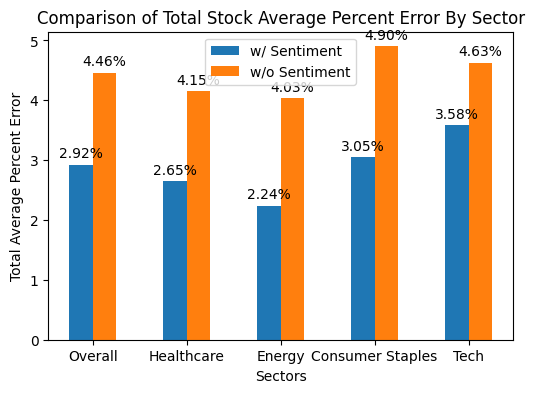

In [59]:
import matplotlib.pyplot as plt

# Data
categories = ['Overall', 'Healthcare', 'Energy', 'Consumer Staples', 'Tech']
values_1 = [2.92, 2.65, 2.24, 3.05, 3.58]
values_2 = [4.46, 4.15, 4.03, 4.90, 4.63]


x = np.arange(len(categories))  # Label locations
width = 0.25  # Bar width

fig, ax = plt.subplots(figsize=(6,4))
rects1 = ax.bar(x - width/2, values_1, width, label='w/ Sentiment')
rects2 = ax.bar(x + width/2, values_2, width, label='w/o Sentiment')

# Labels and formatting
ax.set_xlabel('Sectors')
ax.set_ylabel('Total Average Percent Error')
ax.set_title('Comparison of Total Stock Average Percent Error By Sector')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Show values on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset label
                    textcoords='offset points',
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
plt.savefig("percent_error.png", transparent=True, dpi=300)
plt.show()


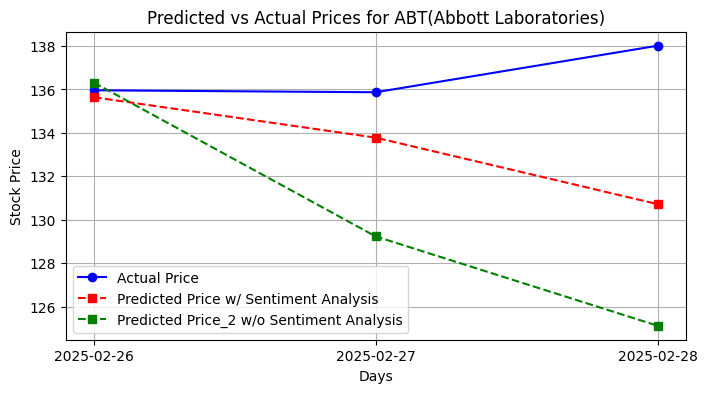

In [60]:
def plot_stock_comparison(stock):
    if stock not in actual_prices or stock not in future_predictions_sen:
        print(f"No data available for {stock}.")
        return

    actual = actual_prices[stock][:3]  # Get first 3 days of actual prices
    predicted_sen = future_predictions_sen[stock][:3]  # Get first 3 days of predictions
    predicted_no_sen = future_predictions_no_sen[stock][:3]  # Get first 3 days of predictions

    if len(actual) < 3 or len(predicted_sen) < 3:
        print(f"Insufficient data to plot for {stock}.")
        return

    days = ["2025-02-26", "2025-02-27", "2025-02-28"]

    plt.figure(figsize=(8, 4), facecolor='none')
    plt.plot(days, actual, marker='o', linestyle='-', label='Actual Price', color='blue')
    plt.plot(days, predicted_sen, marker='s', linestyle='--', label='Predicted Price w/ Sentiment Analysis', color='red')
    plt.plot(days, predicted_no_sen, marker='s', linestyle='--', label='Predicted Price_2 w/o Sentiment Analysis', color='green')

    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.title(f"Predicted vs Actual Prices for {stock}(Abbott Laboratories)")
    plt.legend()
    plt.grid(True)
    plt.savefig("stock_comparison.png", transparent=True, dpi=300)
    plt.show()
    

# Example usage
plot_stock_comparison("ABT") 


/var/folders/20/xhmhdbyx2kj7b8x7lr3qndkh0000gn/T/ipykernel_22421/88842299.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_combined = df_combined.round(2).applymap(lambda x: f"{x}%")


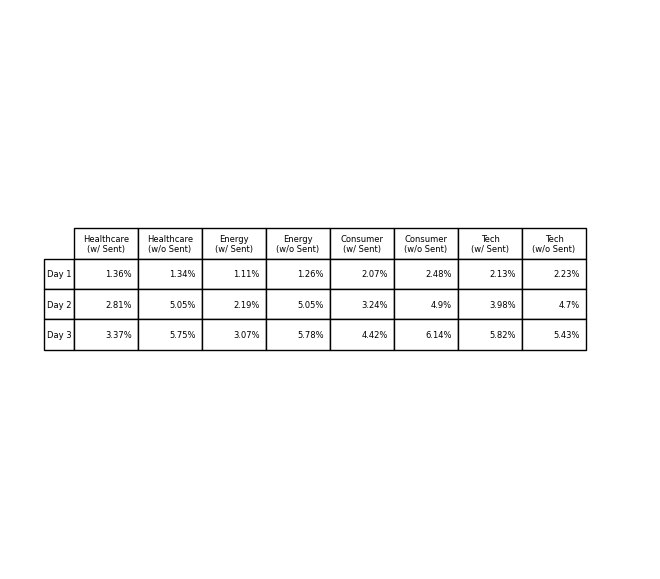

In [76]:
df1 = pd.DataFrame(group_total_errors_sen)
df1.columns = ['Healthcare', 'Energy', 'Consumer', 'Tech']

df2 = pd.DataFrame(group_total_errors)
df2.columns = ['Healthcare', 'Energy', 'Consumer', 'Tech']

# Combining the two DataFrames by alternating columns
df_combined = pd.DataFrame()

for col1, col2 in zip(df1.columns, df2.columns):
    df_combined[col1 + "\n(w/ Sent)"] = df1[col1]
    df_combined[col2 + "\n(w/o Sent)"] = df2[col2]

# Rounding the values to two decimal places and adding percent signs
df_combined = df_combined.round(2).applymap(lambda x: f"{x}%")

# Renaming index
df_combined.index = ["Day 1", "Day 2", "Day 3"]

# Plotting the DataFrame
fig, ax = plt.subplots(figsize=(8, 4))  # Set figure size smaller for tighter layout
ax.axis('off')  # Hide axes

# Creating the table and plotting it
table(ax, df_combined, loc='center', colWidths=[0.1]*len(df_combined.columns))  # Adjust column width

# Adjusting font size to make the boxes smaller
plt.subplots_adjust(left=0.1, right=0.9, top=1.5, bottom=0.1)

# Saving as PNG with transparent background
plt.savefig("dataframe.png", bbox_inches="tight", transparent=True)

plt.show()  # Display the plot if needed


   group_total_errors_sen1         1         2         3         4
0                 1.364170  1.343635  1.259513  2.481024  2.231351
1                 2.811987  5.045047  5.047512  4.899863  4.697547
2                 3.374263  5.748407  5.784609  6.143011  5.433225
